# DSCI 100 Group Project Report - Group 17

## Introduction

Introduction:
* provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
* clearly state the question you tried to answer with your project
* identify and describe the dataset that was used to answer the question



Auditing firms have a very important responsibility in catching fraud cases. Firms performing audits must carefully examine the financial records of businesses to ensure that they are following accounting laws. To properly perform audits, auditors must go through financial records such as receipts, balance sheets, etc. This is a lot of data to analyze. The question we want to answer is: can fruadulent firms can be correctly predicted using risk factors from the dataset and a k-nearest neighbours approach?

The dataset sourced from Hooda et al. (2018) shows annual audit data from 777 firms across 14 different sectors. There are 17 columns of observations in the dataset, the risk class column shows whether the case is fraudulent or not. 

### Variable Information

**Note:** no units were provided for variables

| | Inherent Risk Factors | | Control Risk Factors |
| --- | --- | ---| --- |
| ParaA | Discrepancy in planned-expenditure of inspection and summary report A in Rs | Sector score | Historical risk score value of the target-unit |
| ParaB | Discrepancy in unplanned-expenditure of inspection and summary report B in Rs | Loss | Amount of loss suffered by the firm last year. |
| Total | Total amount of discrepancy found in other reports Rs | History | Average historical loss suffered by firm in the last 10 years. |
| Number | Historical discrepancy score. | District score | Historical risk score of a district in the last 10 years. |
| Money Value | Amount of money involved in misstatements in the past audits. | | |
| Sector ID | Unique ID of the target sector. | Location ID | Unique ID of the city/province. |
| ARS | Total risk score using analytical procedure. | Audit ID | Unique Id assigned to an audit case. |
| Risk class | Risk Class assigned to an audit-case, 1=fraud or 0=no fraud (Target Feature) 

## Methods and Results

Methods & Results:
* describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis. 
* Your report should include code which:
    * loads data from the original source on the web
    * wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
    * performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
    * creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    * performs the data analysis
    * creates a visualization of the analysis 
    * note: all tables and figure should have a figure/table number and a legend
    




In [1]:
# open packages
library(tidyverse)
library(tidymodels)
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Import the data from the url. The data set has 18 columns. We remove the "location_id" column since it's not useful for our analysis. 

In [2]:
# import the data set, make column names consistent
url <- "https://raw.githubusercontent.com/hakkd/dsci-100-project-group17/main/trial.csv"

column_names = c("sector_score", "location_id", "para_a", "score_a", "para_b", "score_b", 
             "total", "numbers", "marks", "money_value", "money_marks", "district", "loss", 
             "loss_score", "history", "history_score", "score", "risk")

audit_data <- read_csv(url, col_names = column_names, skip = 1)

# dropping location_id column (not useful)
audit_data <- select(audit_data, -location_id)

head(audit_data)

Rows: 776 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): location_id
dbl (17): sector_score, para_a, score_a, para_b, score_b, total, numbers, ma...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sector_score,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score,risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,1
3.89,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,0.00,2,0.83,2,0.83,5,2,2.95,2,2,0,2,0,2,2.0,0


**Table 1.** First 6 rows of the audit data set with variable names and data types shown.

Since we want to classify firms by fraud risk, we change the risk column to a factor and recode the values as F = Fraudulent and N = Not Fraudulent for clarity. 

In [3]:
# change Risk to factor and recode as F (fraud) or N (no fraud)
audit_data$risk <- ifelse(audit_data$risk == "1", "F", "N")

audit_data <- audit_data |>
        mutate(risk = as.factor(risk))


We split the data set into training and testing sets, using 75% of the data for training.

In [4]:
set.seed(4321) #set seed

# creating training and testing datasets
audit_split <- initial_split(audit_data, prop = 0.75, strata = risk)

audit_train <- training(audit_split)
audit_test <- testing(audit_split)

Next we check the proportions of fraudulent and not fraudulent firms in the training set.

In [5]:
# check proportion of fraudulent and not fraudulent cases
audit_proportions <- audit_train |>
                      group_by(risk) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(audit_train))

audit_proportions

risk,n,percent
<fct>,<int>,<dbl>
F,364,62.6506
N,217,37.3494


**Table 2.** Proportion of fraudulent and not fraudulent firms in the training set. Approximately 60% of the firms are labelled as fraudulent.

We visualize the distributions of all variables in the training set to identify possible predictors.

Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”


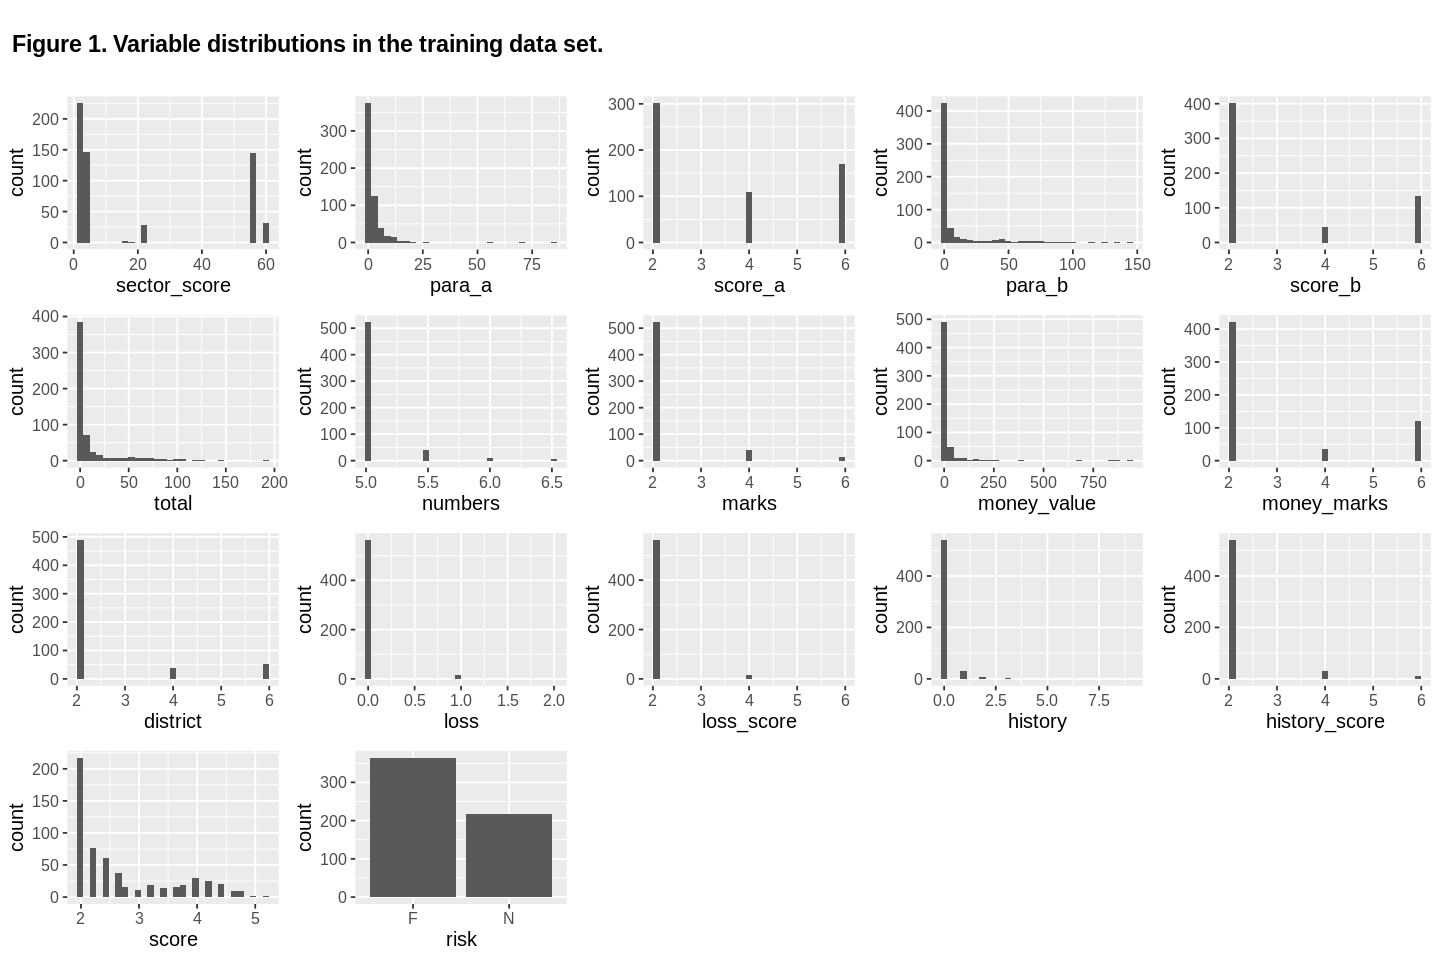

In [6]:
options(repr.plot.width = 12, repr.plot.height = 8)

# show distribution of all variables
# code from:
# https://stackoverflow.com/questions/48507378/plotting-distributions-of-all-columns-in-an-r-data-frame
plots <- lapply(names(audit_train), function(variable_name){
  p <- ggplot(audit_train) +
    aes_string(variable_name) +
    theme(text = element_text(size = 12))

  if(is.numeric(audit_train[[variable_name]])) {
    p <- p + geom_histogram(bins = 30)

  } else {
    p <- p + geom_bar()
  } 
})

title <- ggdraw() + 
  draw_label(
    "Figure 1. Variable distributions in the training data set.",
    fontface = 'bold',
    x = 0,
    hjust = 0) +
  theme(plot.margin = margin(0, 0, 0, 7))

plot_grid(title, plot_grid(plotlist = plots), ncol = 1, rel_heights = c(0.1, 1))

From Figure 1 we see that many of the variables are categorical, not continuous. For our classifier we will focus on the continuous variables total and money_value (see introduction for variable details). Note that para_a and para_b are components of total.

Next we select the total, money_value and risk columns and check if there are any NA values in the training set.

In [7]:
# select columns
audit_train_select <- select(audit_train, total, money_value, risk)

# check how many NA values are in each column (if any)
audit_train_select |>
    map_df(is.na) |>
    map_df(sum)

total,money_value,risk
<int>,<int>,<int>
0,1,0


**Table 3.** There is one column in the training set with a single NA value (money_value). This should be considered for analysis using the money_value variable.

Since there is only a single row in the training data containing an NA value, we will drop the row from the data set.

In [8]:
# drop row containing NA value
audit_train_select <- audit_train_select |> drop_na()

# show mean of all columns grouped by risk
audit_train_select |> 
    group_by(risk) |>
    summarize_all(mean, na.rm = TRUE)

risk,total,money_value
<fct>,<dbl>,<dbl>
F,18.3729962,26.5967308
N,0.5527648,0.2960046


**Table 4.** Means of all variables for fraudulent and not fraudulent firms.

From table 4 we see that there are large differences in the means for the total and money_value variables between the two fraud classes, suggesting that these variables may make good predictors for our knn-classification model. 

For building the knn-classification model, we perform a 5-fold cross validation with 1-20 neighbors using the training data. We standardize the data to ensure that the predictor variables in our classifier have equal importance.

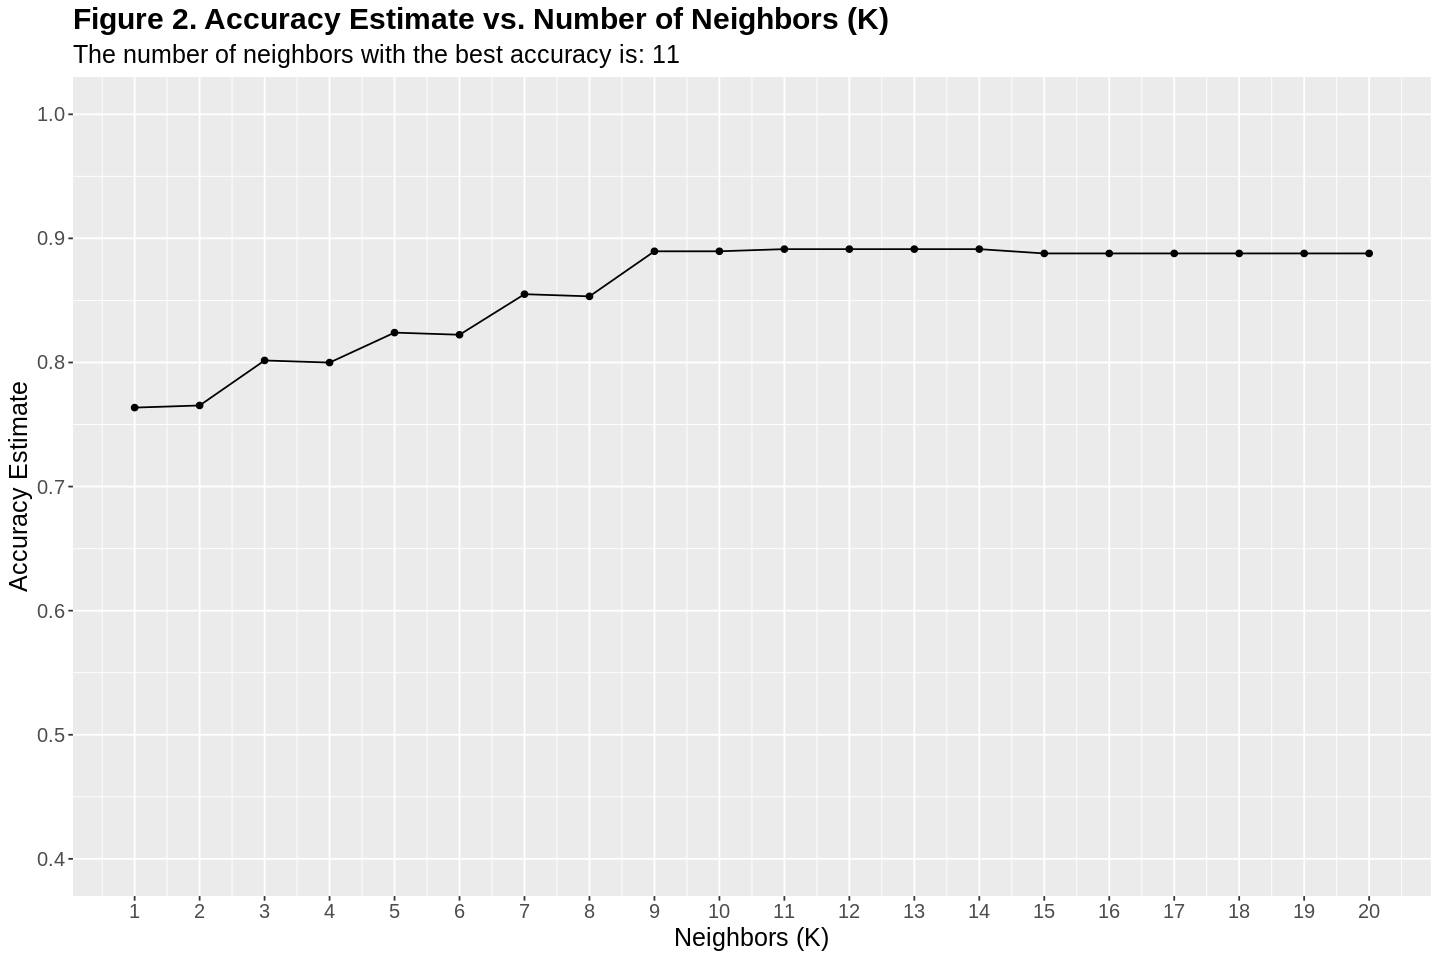

In [9]:
# finding the best k value for k-nn classification
set.seed(4321)

# cross validation with 5 folds
audit_vfold <- vfold_cv(audit_train_select, v = 5, strata = risk)

# recipe
audit_recipe <- recipe(risk ~ total + money_value, data = audit_train_select) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# k-nn tuning
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

ks <- tibble(neighbors = seq(1, 20))

# workflow
training_results <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = audit_vfold, grid = ks) %>%
    collect_metrics()

accuracy <- filter(training_results, .metric == "accuracy")

best_k <- accuracy %>%
    arrange(desc(mean)) %>%
    select(neighbors) %>%
    slice(1)

best_k_text <- paste("The number of neighbors with the best accuracy is:", best_k[1])

# plotting results 
cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors (K)", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(breaks = seq(0, 1, by = 0.1), limits = c(0.4, 1.0)) # adjusting the y-axis

cross_val_plot + 
    ggtitle("Figure 2. Accuracy Estimate vs. Number of Neighbors (K)",
           subtitle = best_k_text) +
    theme(text = element_text(size = 15), plot.title = element_text(face = "bold"))

Figure 2 shows that accuracy generally increases with increasing K for K < 10, after which there is a plateau. We identified K = 11 to produce the greatest accuracy with the training data.

Finally, we apply the knn-classication model with K = 11 to the test data and output the result table, accuracy, and confusion matrix. 

In [10]:
# Building the model with the best k
set.seed(4321)

best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
    set_engine("kknn") %>%
    set_mode("classification")

best_audit_fit <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(best_spec) %>%
    fit(data = audit_train)

# applying model to testing data
audit_predictions <- predict(best_audit_fit, audit_test) %>%
    bind_cols(audit_test)
head(audit_predictions)

.pred_class,sector_score,para_a,score_a,para_b,score_b,total,numbers,marks,money_value,money_marks,district,loss,loss_score,history,history_score,score,risk
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
N,3.89,0.00,2,0.08,2,0.08,5.0,2,0.00,2,2,0,2,0,2,2.0,N
F,3.89,5.43,6,10.77,6,16.20,5.0,2,4.42,2,2,0,2,0,2,3.6,F
F,3.89,8.54,6,31.63,6,40.17,5.0,2,41.28,6,2,0,2,1,4,4.2,F
F,3.89,1.81,4,1.03,2,2.84,5.0,2,0.00,2,2,0,2,0,2,2.2,F
F,3.89,4.86,6,46.78,6,51.64,5.5,4,63.18,6,2,0,2,0,2,4.4,F
F,3.89,7.42,6,2.24,2,9.66,5.0,2,1.25,2,2,0,2,0,2,2.4,F


**Table 5.** Select rows from knn-classification result for testing data. ".pred_class" indicates the prediction applied to each data point. 

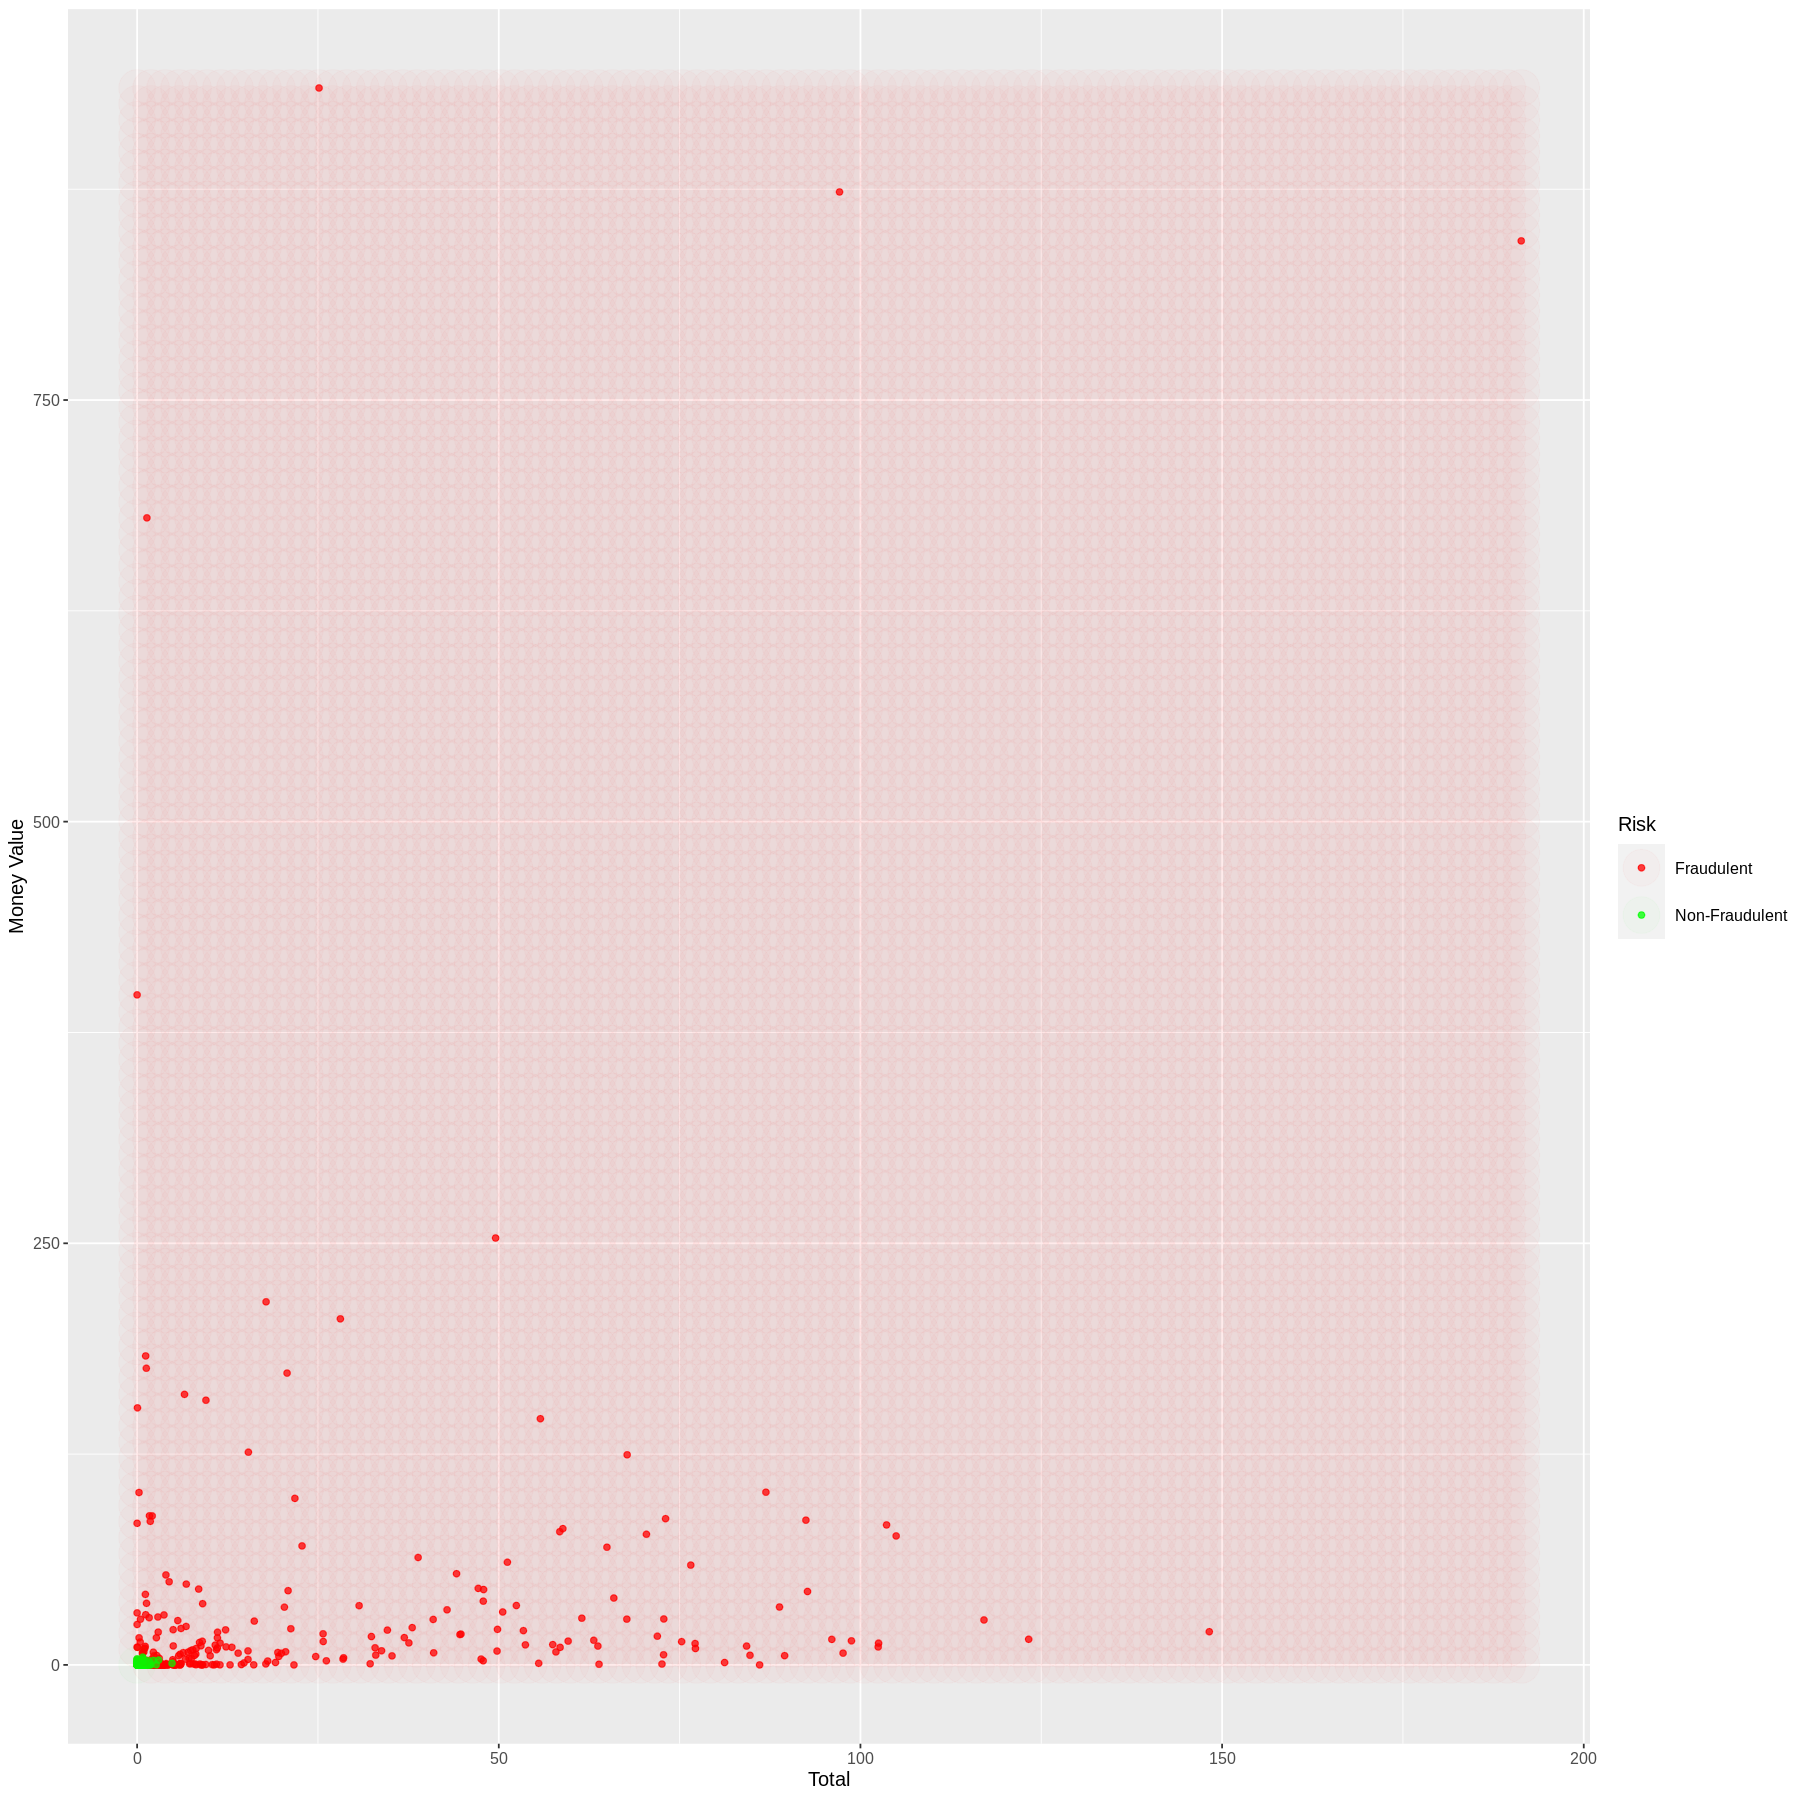

In [14]:
# Visualizing a coloured prediction map

# Create the grid of synthetic new observations
options(repr.plot.width = 15, repr.plot.height = 15)
# Grid for total
total_grid <- seq(min(audit_train_select$total),
                  max(audit_train_select$total), 
                  length.out = 100)

# Grid for money value
mv_grid <- seq(min(audit_train_select$money_value),
                max(audit_train_select$money_value), 
                length.out = 100)

# Combine the two grids
combined_grid <- as_tibble(expand.grid(total = total_grid,
                                       money_value = mv_grid))

# Make predictions with best fit 
prediction_grid <- predict(best_audit_fit, combined_grid) 

prediction_table <- bind_cols(prediction_grid, combined_grid) %>%
    rename(risk = .pred_class)

# Creating the plot
colored_audit_plot <- ggplot() +
    geom_point(data = audit_train_select, 
               mapping = aes(x = total, y = money_value, color = risk),
               alpha = 0.75) +
    geom_point(data = prediction_table, 
                mapping = aes(x = total, y = money_value, color = risk),
                alpha = 0.02,
                size = 10) +
    labs(x = "Total",
         y = "Money Value",
         color = "Risk") +
    scale_color_manual(labels = c("Fraudulent", "Non-Fraudulent"),
                       values = c("red", "green")) +
    theme(text = element_text(size = 12))
colored_audit_plot

In [12]:
# calculating accuracy of predictions
audit_metrics <- audit_predictions %>%
    metrics(truth = risk, estimate = .pred_class)
audit_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8512821
kap,binary,0.6833884


**Table 6.** Accuracy estimate from knn-classification using 11 neighbors. The classification model was able to classify firms in the testing data set with approximately 85% accuracy.

In [13]:
# creating the truth matrix
audit_matrix <- audit_predictions %>%
    conf_mat(truth = risk, estimate = .pred_class)
audit_matrix

          Truth
Prediction   F   N
         F 107  14
         N  15  59

**Table 7.** Confusion matrix showing correct and incorrect classification of the training data. There are roughly equal numbers of false positive and false negative assignments.

## Discussion

Discussion:

* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

We found that, using a KNN classification model, the two variables "total" (which represents the total amount of discrepancy involved in other reports) and "money_value" (which represents the total value of money involved in misstatements in past audits) have an accuracy of approximately 85% in predicting whether a firm is involved in fraudulent activity. We consider this to be a decent result, given that a false positive (\~8% of predictions) or false negative (\~7% of predictions) would not be very detrimental. In the case of a false positive, a further in-depth audit would show that the firm is innocent and has not committed any fraud. The ultimate consequences of this would be dragging firms through long audit processes and wasting auditing resources on unnecessary audits. False negative results are more concerning since a few fraudulent firms may slip through without consequences. However, an 85% accuracy rate in detecting fraudulent firms could act in itself as a deterrent to fraudulent activity. Any government or auditing agency implementing such a model would need to consider whether the cost and time savings of predicting fraudulent activity with this level of accuracy outweigh the costs of letting a few fraudulent firms slip through. 

Our results are within the range that we would expect for a model like this: It's not perfect but it has a good enough accuracy rate that we would disregard it. While the predictions may not be accurate enough to charge a company with fraud, they may give auditors leads on which firms warrant further investigation for fraud. Compared to the results published by Hooda et al. using the same data set, our model had a lower prediction accuracy of 85% vs. 93%. Our knn-classification model is much simpler to implement and interpret than the decision tree, random forest and other models used by Hooda et al.

The current data is used by the Indian government to audit firms in India, but the findings from this report can be applied to other countries and their governments as well. These findings can be used as a starting point to build a model that works best for a country's unique circumstances and can be adapted as needed. 

Some further questions that this could lead to are: 

* Can we use this model for other countries outside of India? How does India differ from other countries in terms of the factors that are highly correlated with fraudulent activities?

* Can not-fraudulent predictions be further classified to reduce the number of false negative results? This may require using additional predictor variables to distinguish small differences in the behaviour of firms.

## References

References:

* At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references)
* Make sure to cite the source of your data as well.



Hooda, Nishtha & Bawa, Seema & Rana, Prashant. (2018). Fraudulent Firm Classification: A Case Study of an External Audit. Applied Artificial Intelligence. 32. 10.1080/08839514.2018.1451032. 